# Import and preprocesing

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from keras.datasets import cifar100
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import densenet
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv2D, MaxPooling2D

#  Load dataset and pre-process data

In [15]:
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Split the data into test and validation data

In [16]:
#Shape of the array
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Number of samples in dataset
print(f"Train: {x_train.shape[0]}")
print(f"Test: {x_test.shape[0]}")

# Data format
print(type(x_train))
print(type(y_train))

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
Train: 50000
Test: 10000
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


# Visualize several images and their classes from the training set

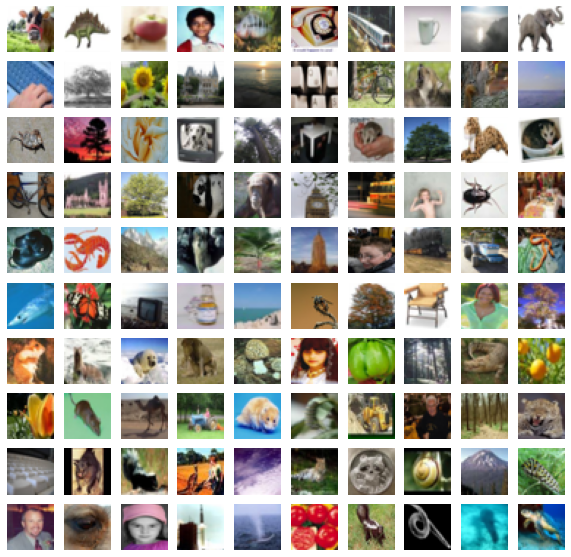

In [17]:
plt.figure(figsize = (10,10))
for i in range(100):
  plt.subplot(10,10,i+1)
  plt.axis('off')
  plt.imshow(x_train[i], cmap = 'gray')

In [18]:
# Dataset class labels
labels =  ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 
           'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 
           'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 
           'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
           'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 
           'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 
           'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 
           'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 
           'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

# Convert labels to one hot encoding matrix

In [20]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train, num_classes = 100)
y_test = to_categorical(y_test, num_classes = 100)
y_val = to_categorical(y_val, num_classes = 100)

In [21]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(40000, 32, 32, 3)
(40000, 100)
(10000, 32, 32, 3)
(10000, 100)
(10000, 32, 32, 3)
(10000, 100)


In [22]:
x_train = x_train / 255
x_val = x_val / 255

# Function for model building
- Build model from DenseNet. Retrain last 5 layers and adds 2 Dense layers.
- param input_shape: shape of single image.
- param n_classes: number of classes for prediction
- return model: compiled model

In [23]:
def build_model(input_shape, n_classes):
    
    base_model = densenet.DenseNet121(input_shape=input_shape,
                                      weights="imagenet",
                                      include_top=False,
                                      pooling='avg')

    for layer in base_model.layers[:-5]:
        layer.trainable = False

    for layer in base_model.layers[-5:]:
        layer.trainable = True

    x = base_model.output

    x = Dense(128)(x)
    x = Activation('relu')(x)
    predictions = Dense(n_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Build model and get summary

In [24]:
model = build_model(input_shape=(32, 32, 3), n_classes=len(labels))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 38, 38, 3)   0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 16, 16, 64)   9408        ['zero_padding2d_2[0][0]']       
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1/conv[0][0]']         

                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 8, 8, 128)   512         ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 8, 8, 128)   0           ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_2_conv (Conv2D)   (None, 8, 8, 32)     36864       ['conv2_block4_1_relu[0][0]']    
                                                                                                  
 conv2_block4_concat (Concatena  (None, 8, 8, 192)   0           ['conv2_block3_concat[0][0]',    
 te)      

 conv3_block2_1_conv (Conv2D)   (None, 4, 4, 128)    20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 4, 4, 128)   512         ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 4, 4, 128)   0           ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_blo

                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 4, 4, 32)     36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 4, 4, 320)   0           ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_block7_0_bn (BatchNormal  (None, 4, 4, 320)   1280        ['conv3_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block7_0_relu (Activatio  (None, 4, 4, 320)   0           ['conv3_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 4, 4, 448)   0           ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 4, 4, 128)    57344       ['conv3_block11_0_relu[0][0]']   
                                                                                                  
 conv3_block11_1_bn (BatchNorma  (None, 4, 4, 128)   512         ['conv3_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_blo

 conv4_block3_0_bn (BatchNormal  (None, 2, 2, 320)   1280        ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 2, 2, 320)   0           ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 2, 2, 128)    40960       ['conv4_block3_0_relu[0][0]']    
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 2, 2, 128)   512         ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 2, 2, 128)   512         ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 2, 2, 128)   0           ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_2_conv (Conv2D)   (None, 2, 2, 32)     36864       ['conv4_block7_1_relu[0][0]']    
                                                                                                  
 conv4_block7_concat (Concatena  (None, 2, 2, 480)   0           ['conv4_block6_concat[0][0]',    
 te)      

 conv4_block11_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 2, 2, 608)   0           ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 2, 2, 608)   2432        ['conv4_block11_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block12_0_relu (Activati  (None, 2, 2, 608)   0           ['conv4_block12_0_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_0_relu (Activati  (None, 2, 2, 736)   0           ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 2, 2, 128)    94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_block16_1_bn (BatchNorma  (None, 2, 2, 128)   512         ['conv4_block16_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_1_relu (Activati  (None, 2, 2, 128)   0           ['conv4_block16_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 2, 2, 128)   0           ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 2, 2, 32)     36864       ['conv4_block20_1_relu[0][0]']   
                                                                                                  
 conv4_block20_concat (Concaten  (None, 2, 2, 896)   0           ['conv4_block19_concat[0][0]',   
 ate)                                                             'conv4_block20_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv4_block24_concat (Concaten  (None, 2, 2, 1024)  0           ['conv4_block23_concat[0][0]',   
 ate)                                                             'conv4_block24_2_conv[0][0]']   
                                                                                                  
 pool4_bn (BatchNormalization)  (None, 2, 2, 1024)   4096        ['conv4_block24_concat[0][0]']   
                                                                                                  
 pool4_relu (Activation)        (None, 2, 2, 1024)   0           ['pool4_bn[0][0]']               
                                                                                                  
 pool4_conv (Conv2D)            (None, 2, 2, 512)    524288      ['pool4_relu[0][0]']             
                                                                                                  
 pool4_pool (AveragePooling2D)  (None, 1, 1, 512)    0           ['pool4_conv[0][0]']             
          

                                                                                                  
 conv5_block4_concat (Concatena  (None, 1, 1, 640)   0           ['conv5_block3_concat[0][0]',    
 te)                                                              'conv5_block4_2_conv[0][0]']    
                                                                                                  
 conv5_block5_0_bn (BatchNormal  (None, 1, 1, 640)   2560        ['conv5_block4_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block5_0_relu (Activatio  (None, 1, 1, 640)   0           ['conv5_block5_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_blo

 conv5_block9_0_relu (Activatio  (None, 1, 1, 768)   0           ['conv5_block9_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block9_1_conv (Conv2D)   (None, 1, 1, 128)    98304       ['conv5_block9_0_relu[0][0]']    
                                                                                                  
 conv5_block9_1_bn (BatchNormal  (None, 1, 1, 128)   512         ['conv5_block9_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block9_1_relu (Activatio  (None, 1, 1, 128)   0           ['conv5_block9_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv5_block13_1_relu (Activati  (None, 1, 1, 128)   0           ['conv5_block13_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block13_2_conv (Conv2D)  (None, 1, 1, 32)     36864       ['conv5_block13_1_relu[0][0]']   
                                                                                                  
 conv5_block13_concat (Concaten  (None, 1, 1, 928)   0           ['conv5_block12_concat[0][0]',   
 ate)                                                             'conv5_block13_2_conv[0][0]']   
                                                                                                  
 conv5_block14_0_bn (BatchNorma  (None, 1, 1, 928)   3712        ['conv5_block13_concat[0][0]']   
 lization)

In [25]:
datagen = ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
)

datagen.fit(x_train)

# Set checkpointer and train model

In [27]:
model_checkpointer = ModelCheckpoint('cifar100_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
history = model.fit(datagen.flow(x_train, y_train, batch_size=128, shuffle=True), validation_data=(x_val, y_val), epochs=40, verbose=1,  
               callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=15), model_checkpointer])

Epoch 1/40
313/313 [==============================] - ETA: 0s - loss: 2.9096 - accuracy: 0.2768
Epoch 1: val_accuracy improved from -inf to 0.31290, saving model to cifar100_best_model.h5
313/313 [==============================] - 80s 256ms/step - loss: 2.9096 - accuracy: 0.2768 - val_loss: 2.6869 - val_accuracy: 0.3129
Epoch 2/40
313/313 [==============================] - ETA: 0s - loss: 2.8408 - accuracy: 0.2910
Epoch 2: val_accuracy improved from 0.31290 to 0.32790, saving model to cifar100_best_model.h5
313/313 [==============================] - 81s 260ms/step - loss: 2.8408 - accuracy: 0.2910 - val_loss: 2.6179 - val_accuracy: 0.3279
Epoch 3/40
313/313 [==============================] - ETA: 0s - loss: 2.7956 - accuracy: 0.2982
Epoch 3: val_accuracy did not improve from 0.32790
313/313 [==============================] - 81s 259ms/step - loss: 2.7956 - accuracy: 0.2982 - val_loss: 2.6227 - val_accuracy: 0.3256
Epoch 4/40
313/313 [==============================] - ETA: 0s - loss: 2.

Epoch 28/40
313/313 [==============================] - ETA: 0s - loss: 2.4947 - accuracy: 0.3589
Epoch 28: val_accuracy did not improve from 0.38230
313/313 [==============================] - 88s 280ms/step - loss: 2.4947 - accuracy: 0.3589 - val_loss: 2.4025 - val_accuracy: 0.3737
Epoch 29/40
313/313 [==============================] - ETA: 0s - loss: 2.4950 - accuracy: 0.3575
Epoch 29: val_accuracy did not improve from 0.38230
313/313 [==============================] - 87s 279ms/step - loss: 2.4950 - accuracy: 0.3575 - val_loss: 2.4160 - val_accuracy: 0.3740
Epoch 30/40
313/313 [==============================] - ETA: 0s - loss: 2.4796 - accuracy: 0.3618
Epoch 30: val_accuracy did not improve from 0.38230
313/313 [==============================] - 88s 280ms/step - loss: 2.4796 - accuracy: 0.3618 - val_loss: 2.3977 - val_accuracy: 0.3775
Epoch 31/40
313/313 [==============================] - ETA: 0s - loss: 2.4841 - accuracy: 0.3592
Epoch 31: val_accuracy did not improve from 0.38230
31

# Evaluate Model
- Show Loss and Accuracy Plots.

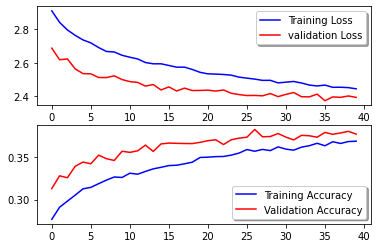

In [29]:
# Show Loss and Accuracy Plots
fig, ax = plt.subplots(2, 1)

ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation Loss",axes=ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r', label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# # Evaluate model on validation data

In [36]:
# Evaluate model on validation data
evaluation_score = model.evaluate(x_test, y_test)
print(f'Evaluation Score: {str(evaluation_score * 100)} %')

313/313 [==============================] - 20s 62ms/step - loss: 32.3049 - accuracy: 0.0448
Evaluation Score: [32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840259552, 32.3049201965332, 0.04479999840

313/313 [==============================] - 19s 58ms/step


NameError: name 'classification_report' is not defined